In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s, in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3 # context length
for w in words[:2]:
    print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


In [5]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [6]:
Xtrain.shape, Ytrain.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [7]:
g = torch.Generator().manual_seed(2147483647) # Generator for reproducibility
C = torch.randn((27, 10), generator=g) # 27 characters with 10 dimensional embeddings
W1 = torch.randn((30, 200)) # 30 dimensional context (3 chars with 10d each) with 200 dimensional hidden layer
B1 = torch.randn(200) # 200 dimensional hidden layer bias
W2 = torch.randn((200, 27)) # 200 dimensional hidden layer with 27 dimensional output (one for each character)
B2 = torch.randn((27))  # 27 dimensional output bias
parameters = [C, W1, B1, W2, B2]
sum(p.nelement() for p in parameters)

11897

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # learning rates

lri = []
lossi = []
stepi = []

In [11]:
for i in range(200000):
 
    # Minibatch of 32 random words
    ix = torch.randint(0, Xtrain.shape[0], (32,))

    # Forward Pass
    emb = C[Xtrain[ix]] # 32, 3, 10 (batch, context, embedding) or 32, 30 (batch, context * embedding)
    h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # 32x30 -> 32x200 (embedding -> hidden)
    logits = h @ W2 + B2 # 32x200 -> 32x27 (hidden -> output)
    loss = F.cross_entropy(logits, Ytrain[ix])

    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    stepi.append(i)
    # lri.append(lre[i])
    lossi.append(loss.log10().item())

print(loss.item())

1.9323151111602783


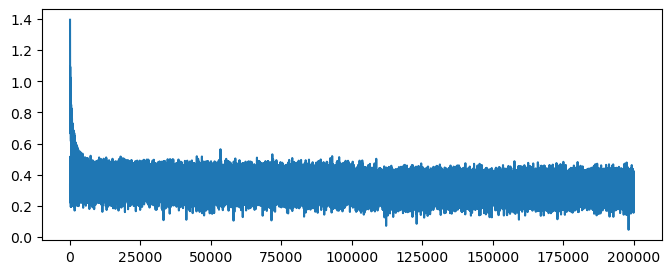

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(stepi, lossi)

In [14]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1298, grad_fn=<NllLossBackward0>)

In [15]:
emb = C[Xtest]
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1314, grad_fn=<NllLossBackward0>)

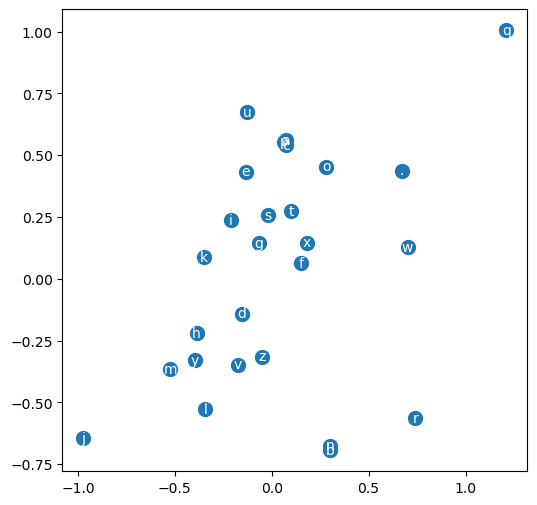

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')

In [19]:
# sample from the model
g = torch.Generator().manual_seed(0)

for _ in range(100):

    out = []
    context = [0] * block_size # initialize with ...
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

kenleigh.
hakeya.
demyla.
saliley.
rion.
kenslynn.
maryla.
kayla.
khylena.
ema.
macyen.
camre.
jeshonni.
shris.
peanzen.
kadyugan.
amiyah.
brus.
yercinorion.
aza.
amarius.
kaydolah.
majadadily.
bour.
knesido.
tre.
camara.
mandel.
talea.
colbell.
briana.
elaniah.
rosalena.
torelle.
herien.
caelee.
bria.
bonny.
kaysel.
brylee.
kayler.
sabaylana.
dazen.
macienly.
elianniell.
mccy.
darrah.
amarte.
omanuvanelleilayson.
dma.
tarie.
teva.
noebnie.
hereonder.
dakyre.
tayeira.
bayse.
lon.
maralaylyna.
zarreya.
abddon.
dian.
pyr.
jadon.
tevo.
maris.
negarshone.
leck.
dorminta.
apelijaharmelie.
kadima.
keyah.
braylene.
jermy.
kend.
raytelansen.
karestinneck.
valyn.
santaviya.
anaalasiette.
nardonte.
mella.
archista.
aublesen.
ahermy.
grei.
genovi.
basnaphia.
macaziyalee.
jianteralyla.
jeovuckendel.
teberlyna.
armett.
azi.
toreecallah.
nila.
artora.
mick.
amarlemarce.
krist.
